#### Clustering and Topic Modeling using NMF

    0) Get the pre-processed [BBC dataset here](http://mlg.ucd.ie/files/datasets/bbc.zip)
    1) There are articles collected from 5 different topics, and the data pre-processed
    2) Use the data to build a sparse matrix (or regular matrix)
    3) run NMF to first do clustering on the articles
    4) use NMF to attempt Topic Modeling

More details on each step:

0) *bbc.terms* is just a list of words and *bbc.docs* is a list of artcles listed by topic. And *bbc.mtx* is a list: first column is **wordID**, second is **articleID** and the third is the number of times that word appeared in that article.

1) To read a file into a list (each line will be a string in that list), you can do this: 

        with open(filename) as f:
            content = f.readlines()
    
2) To build a matrix, all you need is the bbc.mtx file. Look up coo style sparse matrix. Or just build a regular matrix
( I would use a pivot table)

3) Once you have the matrix, it's just a matter of calling NMF with the number of components equals five (we luckily know that there are 5 types of articles in our dataset). NMF will return a N x 5 matrix. For each articles it says how much of each of the 5 topics it belongs to. Take the max and assign each articles to the cooresponding cluster. Since we have the topics for each of the article (in the bbc.docs file), we can compare and see how well our clustering performed.

4) NMF.components_ is a 5 x M matrix. Each feature (topic) has a long vector of words associated with it. Find the top 5 to 10 words for each topic and print them out and see if we can come up with topics based on the set of words.

In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import os
import pandas as pd
import numpy as np
from scipy.io import mmread
import matplotlib.pyplot as plt
%matplotlib inline

### Pairs Solution

In [69]:
m = mmread('/home/cneiderer/Downloads/bbc/bbc.mtx')

In [70]:
m

<9635x2225 sparse matrix of type '<class 'numpy.float64'>'
	with 286774 stored elements in COOrdinate format>

In [110]:
nmf = NMF(n_components=5, init='random', random_state=129)

#### Get word associations with each topic

In [111]:
w = nmf.fit_transform(m)
w.shape

#### Get topic associations with each article

In [139]:
h = nmf.components_
h.shape

(5, 2225)

#### Check NMF Count Estimate

In [140]:
mhat = w.dot(h)

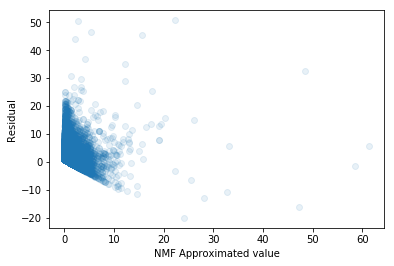

In [141]:
from scipy import sparse

i,j,v = sparse.find(m) 
vhat = [mhat[ii,jj] for (ii,jj) in zip(i,j)]
plt.scatter(vhat, v-vhat, alpha=0.1)
plt.xlabel("NMF Approximated value")
plt.ylabel("Residual");

#### Create topics from words

In [143]:
with open('/home/cneiderer/Downloads/bbc/bbc.terms') as f:
    terms = f.readlines()
terms = [t.split()[0] for t in terms]

In [147]:
topic_words = []
for r in w.T:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:7]
    topic_words.append([terms[e[1]] for e in a])

In [149]:
len(topic_words)

5

In [150]:
topic_words

[['game', 'plai', 'time', 'player', 'world', 'first', 'win'],
 ['best', 'song', 'music', 'year', 'award', 'film', '25'],
 ['year', 'increas', 'wage', 'compani', 'busi', 'minimum', 'govern'],
 ['parti', 'labour', 'govern', 'elect', 'blair', 'peopl', 'tori'],
 ['peopl', 'mobil', 'phone', 'technolog', 'servic', 'music', 'digit']]

In [196]:
orig_topics = [['Business', 0], 
               ['Entertainment', 1],
               ['Politics', 2],
               ['Sports', 3],
               ['Technology', 4]]
orig_topics

[['Business', 0],
 ['Entertainment', 1],
 ['Politics', 2],
 ['Sports', 3],
 ['Technology', 4]]

In [197]:
topics = [['Sports', 0], 
          ['Entertainment', 1], 
          ['Business', 2],
          ['Politics', 3], 
          ['Technology', 4]]
topics

[['Sports', 0],
 ['Entertainment', 1],
 ['Business', 2],
 ['Politics', 3],
 ['Technology', 4]]

In [201]:
pd.concat([pd.DataFrame(orig_topics, columns=['Topic', 'Orig']),
           pd.DataFrame(topics, columns=['Topic', 'New'])], axis=1)

,Topic,Orig,Topic,New
0,Business,0,Sports,0
1,Entertainment,1,Entertainment,1
2,Politics,2,Business,2
3,Sports,3,Politics,3
4,Technology,4,Technology,4


In [211]:
topic_map = {0: 3, 
             1: 1,
             2: 0,
             3: 2,
             4: 4}

#### Check Predictions

In [212]:
pred = h.T.argmax(axis=1)

In [216]:
pred_df = pd.DataFrame(pred, columns=['Pred_Class'])
pred_df.head(5)

,Pred_Class
0,2
1,2
2,2
3,2
4,2


In [217]:
pred_df.Pred_Class = pred_df.Pred_Class.map(topic_map)

In [218]:
file_path = '/home/cneiderer/Downloads/bbc/bbc.classes'

with open(file_path) as f:
    classes = f.readlines()

# remove header
classes = classes[4:]

# strip newlines and split
class_list = [cls.strip('\n').split() for cls in classes]

# create dataframe
class_df = pd.DataFrame(class_list, columns=['Article', 'True_Class']).astype(int)

In [219]:
class_df.head(5)

,Article,True_Class
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [220]:
results_df = pd.concat([class_df, pred_df], axis=1).astype(int)
results_df.head(5)

,Article,True_Class,Pred_Class
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0


In [221]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(results_df.True_Class, results_df.Pred_Class)
print(cm)

[[475   0  16   3  16]
 [ 89 180  39   5  73]
 [ 25   0 387   1   4]
 [ 94  18 109 282   8]
 [  9   3   9  39 341]]


### Pairs Working

In [132]:
file_path = '/home/cneiderer/Downloads/bbc/bbc.mtx'

with open(file_path) as f:
    content = f.readlines()

# remove header
content = content[2:]

content_list = [wd.strip('\n').split() for wd in content]

content_df = pd.DataFrame(content_list, columns=['Word', 'Article', 'Count']).astype(float)
content_df = content_df.astype(int)

In [133]:
content_df.head(5)

,Word,Article,Count
0,1,1,1
1,1,7,2
2,1,11,1
3,1,14,1
4,1,15,2


In [134]:
ptable = content_df.pivot_table(index='Word', columns='Article', values='Count', aggfunc='sum').fillna(0).astype(int)

In [135]:
ptable.shape

(9635, 2225)

In [136]:
ptable.head(10)

Article,1,2,3,4,5,6,7,8,9,10,...,2216,2217,2218,2219,2220,2221,2222,2223,2224,2225
Word,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,2,0,0,0,...,0,1,2,0,0,0,0,0,0,0
2,5,0,4,1,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,1
3,2,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,2,0,0,1,0,0,0,0,0,...,1,0,3,0,1,0,1,1,0,22
5,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,10,0,0,4,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
7,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,1,0,1,2,0,0,1,0,0,0
9,1,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [113]:
nmf = NMF(n_components=5, init='random', random_state=129)

In [114]:
fit = nmf.fit_transform(ptable)

In [115]:
fit.shape

(9635, 5)

In [116]:
fit

array([[  1.66244746e+00,   7.12654609e-01,   1.08743869e+00,
          7.60548514e-01,   5.30694447e-01],
       [  1.00789794e+00,   5.58719980e-01,   2.55974355e+00,
          0.00000000e+00,   3.16439013e-01],
       [  1.24711610e-01,   1.85443588e-01,   6.66173335e-01,
          1.01064773e-01,   4.15396878e-02],
       ..., 
       [  4.93258475e-03,   0.00000000e+00,   2.59755527e-03,
          0.00000000e+00,   2.23248737e-02],
       [  1.14928744e-02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.13163726e-02],
       [  0.00000000e+00,   0.00000000e+00,   1.65784589e-03,
          0.00000000e+00,   1.55905669e-02]])

In [118]:
article_classes = fit.argmax(axis=1)

In [119]:
article_classes[:10]

array([0, 2, 2, 0, 0, 2, 2, 4, 2, 1])

In [ ]:
pred_df = pd.DataFrame()

In [137]:
file_path = '/home/cneiderer/Downloads/bbc/bbc.classes'

with open(file_path) as f:
    classes = f.readlines()

# remove header
classes = classes[4:]

# strip newlines and split
class_list = [cls.strip('\n').split() for cls in classes]

# create dataframe
class_df = pd.DataFrame(class_list, columns=['Article', 'True_Class']).astype(int)

In [138]:
class_df.head(10)

,Article,True_Class
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0
